# CFB Power Rankings

This project aims to develop Power Rankings for each CFB team in a season. Due to the variability of opponents' ability a given statistic will need to be adjusted based on this. These adjustments will be accomplished utilizing ridge regression due to the penalties that it enforces.

### Packages

***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import Ridge

### Reading in Data

In [2]:
cfb_data = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\vs_code\cfb_project\html_data\cleaned_cfb_data.csv')
cfb_data = cfb_data.sort_values('date', ascending=True).reset_index(drop=True)
cfb_data.head(2)

,date,conf,season,team,opponent,location,points_for,points_against,is_win,is_post_season,...,total_yards_allowed,first_downs_allowed_by_pass,first_downs_allowed_by_rush,first_downs_allowed_by_penalty,total_first_downs_allowed,number_of_defense_penality,defensse_penality_yards,fumbles_forced,interception_forced,total_turnovers_forced
0,2022-08-27,Ind,2022,New Mexico State,Nevada,Home,12,23,False,False,...,257,6,11,1,18,6,65,0,0,0
1,2022-08-27,MWC (Mountain),2022,Utah State,Connecticut,Home,31,20,True,False,...,364,8,12,1,21,4,35,1,2,3


### Defining opposite Data Frame

Used for transtlation. May want to add how to rank stat in the future to this table

In [3]:
opposite = {
    'stat': ['team', 'opponent', 'points_for', 'points_against', 'passing_attempts', 'yards_gained_passing', 'tocuhdowns_passing', 'rushing_attempts', 'yards_gained_rushing', 'tocuhdowns_rushing', 'total_offensive_plays', 'total_offensive_yards', 'first_down_gained_by_passing', 'first_down_gained_by_rushing', 'first_down_gained_by_penality', 'total_first_downs_gained', 'number_of_offensive_penality', 'offensive_penality_yards', 'fumbles', 'interceptions', 'turnovers', 'passes_attempted_against', 'yards_allowed_passing', 'touch_downs_allowed_passing', 'rushes_attempted_against', 'yards_allowed_rushing', 'touch_downs_allowed_rushing', 'total_defense_plays', 'total_yards_allowed', 'first_downs_allowed_by_pass', 'first_downs_allowed_by_rush', 'first_downs_allowed_by_penalty', 'total_first_downs_allowed', 'number_of_defense_penality', 'defensse_penality_yards', 'fumbles_forced', 'interception_forced', 'total_turnovers_forced', 'passes_completed_against', 'passing_completion']
, 'opposite': ['opponent',  'team', 'points_against', 'points_for', 'passes_attempted_against', 'yards_allowed_passing', 'touch_downs_allowed_passing', 'rushes_attempted_against', 'yards_allowed_rushing', 'touch_downs_allowed_rushing', 'total_defense_plays', 'total_yards_allowed', 'first_downs_allowed_by_pass', 'first_downs_allowed_by_rush', 'first_downs_allowed_by_penalty', 'total_first_downs_allowed', 'number_of_defense_penality', 'defensse_penality_yards', 'fumbles_forced', 'interception_forced', 'total_turnovers_forced', 'passing_attempts', 'yards_gained_passing', 'tocuhdowns_passing', 'rushing_attempts', 'yards_gained_rushing', 'tocuhdowns_rushing', 'total_offensive_plays', 'total_offensive_yards', 'first_down_gained_by_passing', 'first_down_gained_by_rushing', 'first_down_gained_by_penality', 'total_first_downs_gained', 'number_of_offensive_penality', 'offensive_penality_yards', 'fumbles', 'interceptions', 'turnovers', 'passing_completion', 'passes_completed_against']
}
opposite_frame = pd.DataFrame(opposite)
opposite_dict = opposite_frame.set_index('stat').to_dict()['opposite']
opposite_frame.head()

,stat,opposite
0,team,opponent
1,opponent,team
2,points_for,points_against
3,points_against,points_for
4,passing_attempts,passes_attempted_against


### Adding In FCS Teams

In [4]:
cfb_data['opponent']  = cfb_data['opponent'].where(cfb_data['opponent'].isin(cfb_data['team']), 'FCS')
cfb_data['conf'] = cfb_data['conf'].where(cfb_data['opponent'].isin(cfb_data['team']), 'FCS')
fcs_data = cfb_data[cfb_data['conf'] == 'FCS'].copy()
fcs_data['location'] = np.select([fcs_data['location'] == 'Away', fcs_data['location'] =='Home'], ['Home', 'Away'], default='Netural')
fcs_data['is_win'] = ~ fcs_data['is_win']
fcs_data = fcs_data.rename(
    columns=opposite_dict
)

cfb_data = pd.concat([cfb_data, fcs_data])
cfb_data[cfb_data['team'] == 'FCS'].head(2)

,date,conf,season,team,opponent,location,points_for,points_against,is_win,is_post_season,...,total_yards_allowed,first_downs_allowed_by_pass,first_downs_allowed_by_rush,first_downs_allowed_by_penalty,total_first_downs_allowed,number_of_defense_penality,defensse_penality_yards,fumbles_forced,interception_forced,total_turnovers_forced
3,2022-08-27,FCS,2022,FCS,North Carolina,Away,24,56,False,False,...,608,16,13,0,29,5,45,0,0,0
7,2022-08-27,FCS,2022,FCS,Florida State,Away,7,47,False,False,...,638,7,25,1,33,5,55,0,1,1


### Updating Data Frame

In [5]:
# Upating Win stat
cfb_data['is_win'] = cfb_data['is_win'].astype(int)

In [6]:
# Filtering out post season
regular_season = cfb_data[cfb_data['is_post_season'] == False].copy()

### Grouping Data By Season

Per Game statistics for each team and season

In [7]:
team_per_game = regular_season.groupby(['team', 'season'], as_index=False).agg(
     points_for = ('points_for', 'mean')
    ,points_against = ('points_against', 'mean')
    ,passing_attempts = ('passing_attempts', 'mean')
    ,yards_gained_passing = ('yards_gained_passing', 'mean')
    ,tocuhdowns_passing = ('tocuhdowns_passing', 'mean')
    ,rushing_attempts = ('rushing_attempts', 'mean')
    ,yards_gained_rushing = ('yards_gained_rushing', 'mean')
    ,tocuhdowns_rushing = ('tocuhdowns_rushing', 'mean')
    ,total_offensive_plays = ('total_offensive_plays', 'mean')
    ,total_offensive_yards = ('total_offensive_yards', 'mean')
    ,first_down_gained_by_passing = ('first_down_gained_by_passing', 'mean')
    ,first_down_gained_by_rushing = ('first_down_gained_by_rushing', 'mean')
    ,first_down_gained_by_penality = ('first_down_gained_by_penality', 'mean')
    ,total_first_downs_gained = ('total_first_downs_gained', 'mean')
    ,number_of_offensive_penality = ('number_of_offensive_penality', 'mean')
    ,offensive_penality_yards = ('offensive_penality_yards', 'mean')
    ,fumbles = ('fumbles', 'mean')
    ,interceptions = ('interceptions', 'mean')
    ,turnovers = ('turnovers', 'mean')
    ,passes_attempted_against = ('passes_attempted_against', 'mean')
    ,yards_allowed_passing = ('yards_allowed_passing', 'mean')
    ,touch_downs_allowed_passing = ('touch_downs_allowed_passing', 'mean')
    ,rushes_attempted_against = ('rushes_attempted_against', 'mean')
    ,yards_allowed_rushing = ('yards_allowed_rushing', 'mean')
    ,touch_downs_allowed_rushing = ('touch_downs_allowed_rushing', 'mean')
    ,total_defense_plays = ('total_defense_plays', 'mean')
    ,total_yards_allowed = ('total_yards_allowed', 'mean')
    ,first_downs_allowed_by_pass = ('first_downs_allowed_by_pass', 'mean')
    ,first_downs_allowed_by_rush = ('first_downs_allowed_by_rush', 'mean')
    ,first_downs_allowed_by_penalty = ('first_downs_allowed_by_penalty', 'mean')
    ,total_first_downs_allowed = ('total_first_downs_allowed', 'mean')
    ,number_of_defense_penality = ('number_of_defense_penality', 'mean')
    ,defensse_penality_yards = ('defensse_penality_yards', 'mean')
    ,fumbles_forced = ('fumbles_forced', 'mean')
    ,interception_forced = ('interception_forced', 'mean')
    ,total_turnovers_forced = ('total_turnovers_forced', 'mean')
    ,passes_completed_against = ('passes_completed_against', 'mean')
    ,passing_completion = ('passing_completion', 'mean')
    ,games = ('points_for', 'count')
)
team_per_game.head()

,team,season,points_for,points_against,passing_attempts,yards_gained_passing,tocuhdowns_passing,rushing_attempts,yards_gained_rushing,tocuhdowns_rushing,...,first_downs_allowed_by_penalty,total_first_downs_allowed,number_of_defense_penality,defensse_penality_yards,fumbles_forced,interception_forced,total_turnovers_forced,passes_completed_against,passing_completion,games
0,Air Force,2022,27.666667,13.250000,6.666667,67.750000,0.583333,61.250000,330.916667,2.833333,...,0.416667,13.083333,4.500000,32.416667,0.583333,0.750000,1.333333,13.250000,3.083333,12
1,Air Force,2023,27.583333,17.916667,8.333333,88.333333,0.500000,54.666667,275.750000,2.750000,...,1.083333,14.583333,5.500000,51.583333,0.333333,0.750000,1.083333,16.333333,4.333333,12
2,Akron,2022,21.750000,33.500000,41.833333,283.083333,1.250000,31.083333,89.583333,1.333333,...,2.000000,21.083333,7.916667,64.916667,0.333333,0.750000,1.083333,17.750000,26.916667,12
3,Akron,2023,16.250000,28.000000,35.416667,197.583333,0.833333,28.833333,81.000000,1.000000,...,2.166667,17.916667,4.750000,45.000000,0.500000,0.500000,1.000000,15.500000,21.500000,12
4,Alabama,2022,40.750000,18.000000,34.666667,278.250000,2.666667,35.416667,197.250000,2.083333,...,2.750000,18.583333,6.750000,51.916667,0.583333,0.416667,1.000000,18.333333,22.083333,12


### Creating season stats name

This will be used to itterate through

In [8]:
# Creating stats list
stats_list = [i for i in opposite_frame['stat'].tolist() if 'is_' not in i and i != 'team' and i != 'opponent']
stats_frame = pd.DataFrame({'stat': stats_list})
# Season List
season_list = regular_season['season'].unique().tolist()
season_frame = pd.DataFrame({'season': season_list})

# Season Stats
season_stat = pd.merge(
     left= season_frame
    ,right= stats_frame
    ,how='cross'
)

season_stat.head(2)

,season,stat
0,2022,points_for
1,2022,points_against


### Creating Adjustments

***

Simply put this adjsutment will be adjusted_stat = intercept + team rating + opponent rating + home advanatge 
To find these inputs ridge regression was used

#### Unpivoting Season Stats 

In [9]:
team_season_unpivot = pd.melt(
     team_per_game[['team', 'season'] + stats_list]
    ,id_vars = ['team', 'season']
    ,value_vars = stats_list
    ,var_name = 'stat'
    ,value_name= 'raw_stat'
)
team_season_unpivot.head()

,team,season,stat,raw_stat
0,Air Force,2022,points_for,27.666667
1,Air Force,2023,points_for,27.583333
2,Akron,2022,points_for,21.750000
3,Akron,2023,points_for,16.250000
4,Alabama,2022,points_for,40.750000


#### Adding UID for team and season and opponent and season

In [10]:
# Team Season Code
regular_season['team_season_code'] = regular_season['team'].astype(str) + '_' + regular_season['season'].astype(str)

# Oppoent Season Code
regular_season['opponent_season_code'] = regular_season['opponent'].astype(str) + '_' + regular_season['season'].astype(str)

#### Setting Location as int

In [11]:
loca_critera = [regular_season['location'] == 'Home', regular_season['location'] ==  'Away', regular_season['location'] ==  'Neutral']
loca_selection = [True, False, False]
regular_season['team_has_home_feild_advantage'] = np.select(loca_critera, loca_selection)

#### Setting up Ridge Regresion to find intercepts

In [12]:
ridge_reg = Ridge(alpha=1, fit_intercept=True)

#### Setting up returns

In [13]:
results_frame = pd.DataFrame(columns=['season', 'stat', 'uid', 'regression_coef', 'regression_value'])

#### Itterating through season stats 

In [14]:
for index, row in season_stat.iterrows():
    season = row['season']
    stat = row['stat']
    # Used Columns
    used_columns = ['team_season_code', 'opponent_season_code', 'team_has_home_feild_advantage', stat]
    # Filtering to this season and only wanted columns
    this_season_games = regular_season[regular_season['season'] == season][used_columns].reset_index(drop=True)
    # Establishing Dummy variables 
    dummies = pd.get_dummies(this_season_games[['team_season_code', 'opponent_season_code', 'team_has_home_feild_advantage']])
    
    # Fiiting Ridge Regression
    ridge_reg.fit(
         X = dummies
        ,y = this_season_games[[stat]]
    )
   
    # Storing Results 
    dic = {
             'season': season
            ,'stat': stat
            ,'uid': dummies.columns
            ,'regression_coef': ridge_reg.coef_[0]
        }
    frame = pd.DataFrame(dic)
    frame['regression_value'] = frame['regression_coef'] + ridge_reg.intercept_
    results_frame = pd.concat([results_frame, frame], ignore_index=True)

results_frame.head()


C:\Users\brand\AppData\Local\Temp\ipykernel_23364\1985611207.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_frame = pd.concat([results_frame, frame], ignore_index=True)


,season,stat,uid,regression_coef,regression_value
0,2022,points_for,team_has_home_feild_advantage,3.324785,28.911955
1,2022,points_for,team_season_code_Air Force_2022,-3.146485,22.440685
2,2022,points_for,team_season_code_Akron_2022,-8.257004,17.330167
3,2022,points_for,team_season_code_Alabama_2022,12.455148,38.042318
4,2022,points_for,team_season_code_Appalachian State_2022,5.575896,31.163067


#### Filtering Results to be team specfic

In [15]:
team_season_adjusted = results_frame[results_frame['uid'].str.contains('team_season_code')].copy()
team_season_adjusted['uid'] = team_season_adjusted['uid'].str.replace('team_season_code_', '')
team_season_adjusted['team'] = team_season_adjusted['uid'].str.split('_', expand=True)[0]
team_season_adjusted = team_season_adjusted.rename(
    columns= {'regression_value': 'adj_stat'}
)
team_season_adjusted = team_season_adjusted[['team' , 'season', 'stat', 'adj_stat']]
team_season_adjusted.head()

,team,season,stat,adj_stat
1,Air Force,2022,points_for,22.440685
2,Akron,2022,points_for,17.330167
3,Alabama,2022,points_for,38.042318
4,Appalachian State,2022,points_for,31.163067
5,Arizona State,2022,points_for,23.011336


#### Merging in Raw and Adj

In [16]:
team_season_raw_and_adjusted = pd.merge(
     left = team_season_unpivot
    ,right = team_season_adjusted
    ,on = ['team', 'season', 'stat']
    ,how = 'outer'
)
team_season_raw_and_adjusted.head()

,team,season,stat,raw_stat,adj_stat
0,Air Force,2022,defensse_penality_yards,32.416667,33.896507
1,Air Force,2022,first_down_gained_by_passing,2.333333,2.634823
2,Air Force,2022,first_down_gained_by_penality,0.750000,0.897043
3,Air Force,2022,first_down_gained_by_rushing,17.333333,16.109670
4,Air Force,2022,first_downs_allowed_by_pass,7.000000,10.553824


### Creating Raitings

***

#### Season Averages

In [17]:
season_mean_sd = team_season_raw_and_adjusted.groupby(['season', 'stat'], as_index=False).agg(
     raw_stat_mean = ('raw_stat', 'mean')
    ,raw_stat_std = ('raw_stat', 'std')
    ,adj_stat_mean = ('adj_stat', 'mean')
    ,adj_stat_std = ('adj_stat', 'std')
)
season_mean_sd.head(2)

,season,stat,raw_stat_mean,raw_stat_std,adj_stat_mean,adj_stat_std
0,2022,defensse_penality_yards,52.704072,9.036719,51.716936,7.672350
1,2022,first_down_gained_by_passing,10.273250,2.500220,10.065289,2.320996


#### Meerging in season averages

In [18]:
team_season_raiting = pd.merge(
     left = team_season_raw_and_adjusted
    ,right = season_mean_sd
    ,on = ['season' , 'stat']
    ,how = 'left'
)
team_season_raiting.head(2)

,team,season,stat,raw_stat,adj_stat,raw_stat_mean,raw_stat_std,adj_stat_mean,adj_stat_std
0,Air Force,2022,defensse_penality_yards,32.416667,33.896507,52.704072,9.036719,51.716936,7.672350
1,Air Force,2022,first_down_gained_by_passing,2.333333,2.634823,10.273250,2.500220,10.065289,2.320996


#### Establishing teams to include

In [19]:
team_season_raiting['include_rank'] = np.where(team_season_raiting['team'] == 'FCS', 0, 1)

#### Creating Rankings

In [20]:
for type in ['raw', 'adj']:
    # Rating teams based on distance from mean and STD
    team_season_raiting[type + '_raiting'] = scipy.stats.norm.cdf(
        (team_season_raiting[type + '_stat'] 
         - team_season_raiting[type + '_stat_mean'])
        / team_season_raiting[type + '_stat_std']
    )

    # Ranking
    team_season_raiting[type + '_rank'] = np.where(
        team_season_raiting['include_rank'] == 0 , np.nan, 
        team_season_raiting.groupby(['season', 'stat', 'include_rank'])[type + '_raiting'].rank(ascending=False)
    )

team_season_raiting.head(2)

,team,season,stat,raw_stat,adj_stat,raw_stat_mean,raw_stat_std,adj_stat_mean,adj_stat_std,include_rank,raw_raiting,raw_rank,adj_raiting,adj_rank
0,Air Force,2022,defensse_penality_yards,32.416667,33.896507,52.704072,9.036719,51.716936,7.672350,1,0.012384,130.0,0.010098,131.0
1,Air Force,2022,first_down_gained_by_passing,2.333333,2.634823,10.273250,2.500220,10.065289,2.320996,1,0.000747,130.0,0.000684,130.0


#### Selecting wanted columns

In [21]:
team_season_rankings = team_season_raiting[['season', 'team', 'stat', 'raw_stat', 'raw_raiting', 'raw_rank', 'adj_stat', 'adj_raiting', 'adj_rank']].copy()
team_season_rankings['rank_delta'] = team_season_rankings['raw_rank'] - team_season_rankings['adj_rank']
team_season_rankings.head(2)

,season,team,stat,raw_stat,raw_raiting,raw_rank,adj_stat,adj_raiting,adj_rank,rank_delta
0,2022,Air Force,defensse_penality_yards,32.416667,0.012384,130.0,33.896507,0.010098,131.0,-1.0
1,2022,Air Force,first_down_gained_by_passing,2.333333,0.000747,130.0,2.634823,0.000684,130.0,0.0


### Exploring Adjustments

***

Still need to add in how to rank certain stats
Such as points_allowed should be ranked descending

#### Scatter

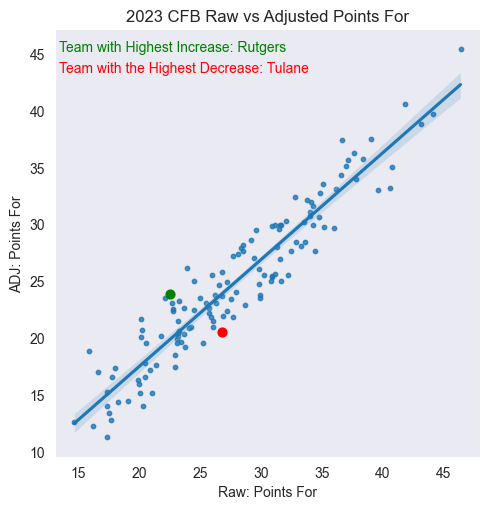

In [22]:
season = 2023
stat = 'points_for'
season_data = team_season_rankings[team_season_rankings['season'] == season].copy()
season_stat_data = season_data[season_data['stat'] == stat].copy()
stat_name = stat.replace('_', " ").title()
season_stat_data = season_stat_data.dropna()
season_stat_data = season_stat_data.sort_values('rank_delta', ascending=False).reset_index(drop=True)

# Graphing
sns.set_style("dark")
sns.lmplot(
     x = 'raw_stat'
    ,y = 'adj_stat'
    ,data= season_stat_data
    ,scatter_kws={'s': 10}
)

# Adding Highest Rank Increase
plt.scatter(season_stat_data.iloc[0]['raw_stat'], season_stat_data.iloc[0]['adj_stat'], color='green', s=40)
plt.gca().annotate(
     f'Team with Highest Increase: {season_stat_data.iloc[0]['team']}'
    ,xy = (season_stat_data.iloc[0]['raw_stat'], season_stat_data.iloc[0]['adj_stat'])
    ,xytext = (0.01, .95)
    ,textcoords='axes fraction'
    ,color = 'green'
)
# Adding Highest Rank Decrease
plt.scatter(season_stat_data.iloc[-1]['raw_stat'], season_stat_data.iloc[-1]['adj_stat'], color='red', s=40)
plt.gca().annotate(
     f'Team with the Highest Decrease: {season_stat_data.iloc[-1]['team']}'
    ,xy = (season_stat_data.iloc[-1]['raw_stat'], season_stat_data.iloc[-1]['adj_stat'])
    ,xytext = (0.01, .9)
    ,textcoords='axes fraction'
    ,color = 'red'
)
plt.title(f'{season} CFB Raw vs Adjusted {stat_name}')
plt.xlabel(f'Raw: {stat_name}')
plt.ylabel(f'ADJ: {stat_name}')
plt.show()


### Saving Adjusted Data 

***

#### Pivoting Data

In [23]:
pivoted_data = pd.pivot(
    team_season_rankings
    ,index=['team', 'season']
    ,columns='stat'
    ,values='adj_raiting'
)
pivoted_data.columns.name = None
pivoted_data = pivoted_data.reset_index()
pivoted_data.head()

,team,season,defensse_penality_yards,first_down_gained_by_passing,first_down_gained_by_penality,first_down_gained_by_rushing,first_downs_allowed_by_pass,first_downs_allowed_by_penalty,first_downs_allowed_by_rush,fumbles,...,total_offensive_yards,total_turnovers_forced,total_yards_allowed,touch_downs_allowed_passing,touch_downs_allowed_rushing,turnovers,yards_allowed_passing,yards_allowed_rushing,yards_gained_passing,yards_gained_rushing
0,Air Force,2022,0.010098,0.000684,0.039625,0.999965,0.552092,0.013407,0.045617,0.916693,...,0.456708,0.333310,0.135376,0.350532,0.244139,0.182360,0.485196,0.057842,0.000620,0.999862
1,Air Force,2023,0.613362,0.001585,0.846747,0.997539,0.167665,0.178251,0.116609,0.785160,...,0.274694,0.142740,0.086624,0.421025,0.225189,0.376600,0.233517,0.072767,0.002457,0.997296
2,Akron,2022,0.811447,0.860663,0.827412,0.158076,0.503471,0.626811,0.685886,0.935590,...,0.237267,0.139955,0.732822,0.700164,0.829827,0.967692,0.742398,0.633622,0.718341,0.049628
3,Akron,2023,0.262345,0.179777,0.256291,0.178011,0.230165,0.796261,0.686451,0.550959,...,0.028577,0.114126,0.580025,0.806283,0.883180,0.916286,0.393956,0.706119,0.243067,0.020853
4,Alabama,2022,0.263011,0.848173,0.636160,0.613265,0.140970,0.945443,0.150468,0.543749,...,0.905617,0.095848,0.038760,0.039633,0.138904,0.572944,0.064487,0.104429,0.811093,0.773925


#### Exporting Data

In [24]:
pivoted_data.to_csv('adjusted_cfb_data.csv', index=False)